# Анализ бизнес-показателей развлекательного приложения Procrastinate Pro+


Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года: лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы.

**Цель исследования:** разобраться в причинах, почему компания терпит убытки, несмотря на огромные вложения в рекламу.

**В ходе исследования необходимо изучить**: 
 - откуда приходят пользователи и какими устройствами они пользуются,
 - сколько стоит привлечение пользователей из различных рекламных каналов;
 - сколько денег приносит каждый клиент,
 - когда расходы на привлечение клиента окупаются,
 - какие факторы мешают привлечению клиентов.
 
**Описание данных:**

1) файл **visits_info_short.csv** хранит лог сервера с информацией о посещениях сайта:
  - user_id — уникальный идентификатор пользователя,
  - region — страна пользователя,
  - device — тип устройства пользователя,
  - channel — идентификатор источника перехода,
  - session Start — дата и время начала сессии,
  - session End — дата и время окончания сессии.

2) файл **orders_info_short.csv** — информацию о заказах:
  - user_id — уникальный идентификатор пользователя,
  - event_dt — дата и время покупки,
  - revenue — сумма заказа.
  
3) файл **costs_info_short.csv**— информацию о расходах на рекламу: 
  - dt — дата проведения рекламной кампании,
  - channel — идентификатор рекламного источника,
  - costs — расходы на эту кампанию.

### Загрузка и подготовка данных к анализу

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Выгрузим информацию о визитах, заказах и расходах в переменные visits, orders и costs соответственно, и посмотрим общую информацию о данных.

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    print(visits.head())
except:
    print('Неверно указан путь к файлу')
   

        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    print(orders.head())
except:
    print('Неверно указан путь к файлу')

        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
    print(costs.head())
except:
    print('Неверно указан путь к файлу')

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Во всех трех получившихся датафреймах нет пропусков, однако есть несоответствие типам данных колонок, в которых хранится информация с датами - в каждом из датафреймов это тип object. Изменим тип object на datetime. Также приведем названия колонок в получившихся дф к нижнему регистру.

In [8]:
# приводим названия колонок к нижнему регистру
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

Приведем названия столбцов к snake_case стилю.

In [9]:
visits.rename(columns={'user id' : 'user_id',
                      'session start': 'session_start',
                      'session end': 'session_end'}, inplace=True)

visits.head()

user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [10]:
orders.rename(columns={'user id':'user_id',
                      'event dt':'event_dt'}, inplace=True)
orders.head()

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [11]:
# в visits меняем тип колонок session start и session end на datetime

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [12]:
# в orders меняем тип event dt на datetime

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [13]:
# в costs меняем тип dt на datetime date
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Проверим данные на наличик явных дубликатов.

In [14]:
visits.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

In [16]:
costs.duplicated().sum()

0

**Вывод:** на этапе загрузки и подготовки данных были созданы три датафрейма *visits*, *orders*, *costs*, которые хранят данные о посещениях, покупках и расходах на рекламу соответственно. Названия столбцов в каждом из df были приведены к нижнему регистру, была сделана проверка на пропуски, измнен тип данных дат на datetime, проведена проверка датафреймов на наличие в них явных дубликатов - дубликаты отсутствуют. Данные готовы к следующему этапу анализа.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.



Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**Функция для создания пользовательских профилей**

In [17]:
def get_profiles(visits, orders, ad_costs):
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    profiles['europe'] = profiles['region'].isin(['France', 'Germany', 'UK'])
    profiles['us'] = profiles['region'].isin(['United States'])

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
        )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'costs', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
            )
    profiles['costs'] = profiles['costs'].fillna(0)
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**Функция для расчёта удержания**

In [18]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    
    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
 
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

**Функция для расчёта конверсии**

In [19]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days


    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']


    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)


        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result


    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)


    if 'cohort' in dimensions: 
        dimensions = []


    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

**Функция для расчёта LTV и ROI**

In [20]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']


    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )

        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)

        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes

        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [21]:
# filter_data() — для сглаживания данных
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция для визуализации удержания**

In [22]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Функция для визуализации конверсии**

In [23]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция для визуализации LTV и RO**I

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)   
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Вывод:** в данном пункте были реализованы функции для расчета LTV, CAC, ROI, Retention Rate и Conversion Rate, а также функции для визуализации этих показателей.

### Исследовательский анализ данных

- Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [25]:
profiles = get_profiles(visits, orders, costs)

profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  europe     us  costs  acquisition_cost  
0  2019-05-07 2019-05-01   True   False   True  101.2          1.088172  
1  2019-07-09 2019-07-01  False   False   True  168.3          1.107237  
2  2019-10-01 2019-10-01  False    True  False    0.0          0.000000  
3  2019-08-22 2019-08-01  False    True  False   16.8          0.988235  
4  2019-10-02 2019-10-01  False   False   True    6.0          0.230769

In [26]:
#Минимальная и максимальная даты привлечения пользователей

min_users_date = profiles['dt'].min()
max_users_date = profiles['dt'].max()

print(f'Минимальная дата привлечения пользователей: {min_users_date}')
print(f'Максимальная дата привлечения пользователей: {max_users_date}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


**Вывод:** иходя из описания данных и проведенных расчетов можно сказать, что первый пользователь, воспользовавшийся приложением  Procrastinate Pro+ пришел 01.05.2019, последний - 27.10.2019

**Для составления портета пользователей были написаны две функции: grouped_function для группировки данных по заданному признаку, plot_grouped - для визуализации долей пользователей по заданному признаку.**

In [27]:
def grouped_function(dimension):
    dimension_grouped = (profiles.groupby(dimension)
                  .agg({'user_id' : 'nunique'})
                  .rename(columns={'user_id':'total_users'}))
    dimension_grouped_payers = (profiles.query('payer == True')
                         .groupby(dimension)
                         .agg({'user_id': 'nunique'})
                         .rename(columns={'user_id':'total_payers'})
                         .sort_values(by='total_payers', ascending=False))
    total_grouped = dimension_grouped_payers.merge(dimension_grouped['total_users'], on=dimension, how='left')
    total_grouped['payers_percent'] = total_grouped['total_payers'] / total_grouped['total_users'] * 100
    
    return dimension_grouped, dimension_grouped_payers, total_grouped

In [28]:
def plot_grouped(grouped, payers_grouped, total_title, payers_title):
    plt.figure(figsize=(20, 10))

    ax1 = plt.subplot(1, 3, 1)
    grouped.plot(kind='pie', y='total_users', autopct='%.0f%%', title = total_title, ax=ax1)

    ax2 = plt.subplot(1,3,2)
    payers_grouped.plot(kind='pie', y='total_payers', autopct='%.0f%%', 
                           title = payers_title, ax=ax2)

    plt.show()

- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [29]:
region_grouped, region_grouped_payers, total_grouped = grouped_function('region')
total_grouped

total_payers  total_users  payers_percent
region                                                  
United States          6902       100002        6.901862
UK                      700        17575        3.982930
France                  663        17450        3.799427
Germany                 616        14981        4.111875

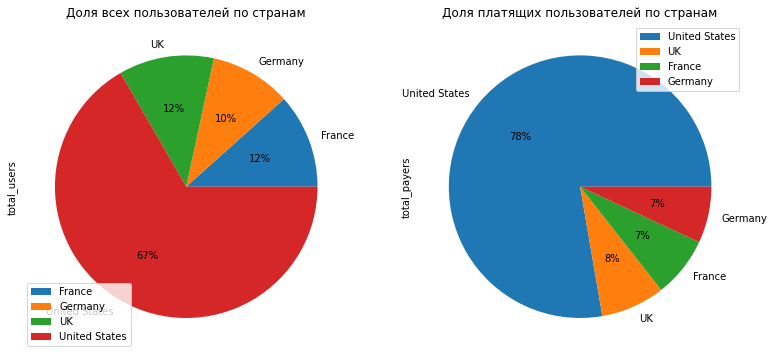

In [30]:
total_title = 'Доля всех пользователей по странам'
payers_title = 'Доля платящих пользователей по странам'

plot_grouped(region_grouped, region_grouped_payers, total_title, payers_title)

**Вывод:** пользователи проживают в США, Англии, Франции и Германии. Лидер по кол-ву пользователей США - более 100 тыс, при этом платящих пользователей менее 7 тыс, что составляет около 7%, достаточно маленький показатель для такого количества пользоваталей. Пользователей из Англии и Франции почти одинаковое кол-во, также как и кол-во платящих пользоваталей, однако доля платящих составляет менее 4% - маленький показатель. На последнем месте по кол-ву пользователей стоит Германия, однако доля платящих пользователей выше, чем у Англии и Франции - более 4%, но это все равно достаточно низкий показатель.

- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [31]:
device_grouped, device_grouped_payers, total_grouped = grouped_function('device')
total_grouped

total_payers  total_users  payers_percent
device                                            
iPhone           3382        54479        6.207897
Android          2050        35032        5.851793
Mac              1912        30042        6.364423
PC               1537        30455        5.046790

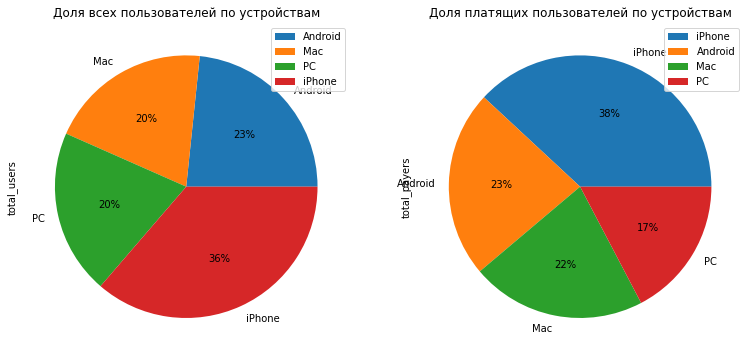

In [32]:
total_title = 'Доля всех пользователей по устройствам'
payers_title = 'Доля платящих пользователей по устройствам'

plot_grouped(device_grouped, device_grouped_payers, total_title, payers_title)

**Вывод:** устройства, которыми пользуются пользователи - IPhone, Android, Mac и PC. Лидером среди платящих пользоваталей, также как и для всех пользователей, является IPhone - более 3тыс и почти 55тыс соответственно, однако доля платящих чуть больше 6%. Разница между кол-вом платящих пользоваталей Android и Mac чуть больше тысячи, однако доля платящих относительно всех пользоваталей у Mac выше, чем у Android и Iphone - 6.4% и 5.9% соответственно. На последнем месте стоит PC - всего пользователей 30455, из них платящих - 1537, что составлет примерно 5%.

В целом, если посмотреть на долю платящих пользователей по устройствам то значения располагаются от 5% до 7%, достаточно низких процент.

In [33]:
def get_device_by_region(region, column_name):
    device_by_region = (profiles.query('region == @region').groupby('device')
                  .agg({'user_id' : 'nunique'})
                  .rename(columns={'user_id': column_name})
                  .sort_values(by=column_name, ascending=False))
    return device_by_region

In [34]:
us = 'United States'
column_name = 'total_users_us'
us_device_grouped = get_device_by_region(us, column_name)
us_device_grouped

total_users_us
device                 
iPhone            44529
Mac               24842
Android           20199
PC                10432

In [35]:
gr = 'Germany'
column_name = 'total_users_gr'
gr_device_grouped = get_device_by_region(gr, column_name)
gr_device_grouped

total_users_gr
device                 
PC                 5945
Android            4440
iPhone             3012
Mac                1584

In [36]:
uk = 'UK'
column_name = 'total_users_uk'
uk_device_grouped = get_device_by_region(uk, column_name)
uk_device_grouped

total_users_uk
device                 
PC                 7138
Android            5141
iPhone             3518
Mac                1778

In [37]:
fr = 'France'
column_name = 'total_users_fr'
fr_device_grouped = get_device_by_region(fr, column_name)
fr_device_grouped

total_users_fr
device                 
PC                 6940
Android            5252
iPhone             3420
Mac                1838

In [38]:
# объеденим все полученные таблицы
total_table = us_device_grouped.merge(uk_device_grouped['total_users_uk'], on='device', how='left')
total_table = total_table.merge(fr_device_grouped['total_users_fr'], on='device', how='left')
total_table = total_table.merge(gr_device_grouped['total_users_gr'], on='device', how='left')
total_table

total_users_us  total_users_uk  total_users_fr  total_users_gr
device                                                                 
iPhone            44529            3518            3420            3012
Mac               24842            1778            1838            1584
Android           20199            5141            5252            4440
PC                10432            7138            6940            5945

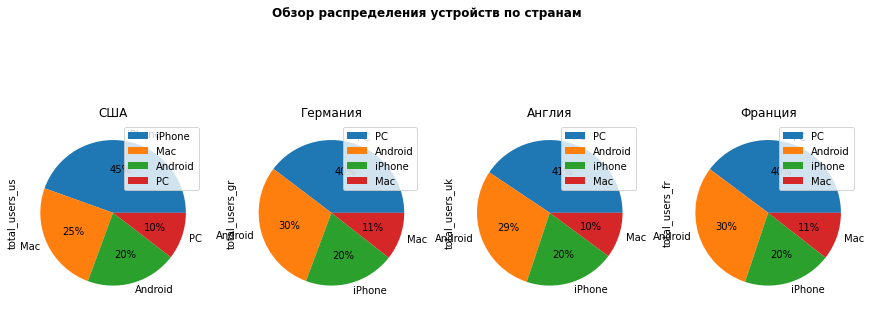

In [39]:
plt.figure(figsize=(15, 6))

plt.suptitle('Обзор распределения устройств по странам', fontweight='bold')

ax1 = plt.subplot(1, 4, 1)
total_title = 'США'
us_device_grouped.plot(kind='pie', y='total_users_us', autopct='%.0f%%', title = total_title, ax=ax1)

ax2 = plt.subplot(1, 4, 2)
total_title = 'Германия'
gr_device_grouped.plot(kind='pie', y='total_users_gr', autopct='%.0f%%', title = total_title, ax=ax2)

ax3 = plt.subplot(1, 4, 3)
total_title = 'Англия'
uk_device_grouped.plot(kind='pie', y='total_users_uk', autopct='%.0f%%', title = total_title, ax=ax3)

ax4 = plt.subplot(1, 4, 4)
total_title = 'Франция'
fr_device_grouped.plot(kind='pie', y='total_users_fr', autopct='%.0f%%', title = total_title, ax=ax4)

plt.show()

**Вывод:** в Европе стабильно лидирующую позицию среди всех стран занимает PC, на втором месте Anderoid, в США же iPhone и Mac в лидерах. Вот здесь можно сдлеать вывод, что лидирующее место среди всех пользователей занимают пользователи iPhone и Mac, потому что пользователей из США почти в 10 раз больше.

- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [40]:
channel_grouped, channel_grouped_payers, total_grouped = grouped_function('channel')
total_grouped

total_payers  total_users  payers_percent
channel                                                      
FaceBoom                    3557        29144       12.204914
TipTop                      1878        19561        9.600736
organic                     1160        56439        2.055316
WahooNetBanner               453         8553        5.296387
AdNonSense                   440         3880       11.340206
RocketSuperAds               352         4448        7.913669
LeapBob                      262         8553        3.063253
OppleCreativeMedia           233         8605        2.707728
lambdaMediaAds               225         2149       10.469986
YRabbit                      165         4312        3.826531
MediaTornado                 156         4364        3.574702

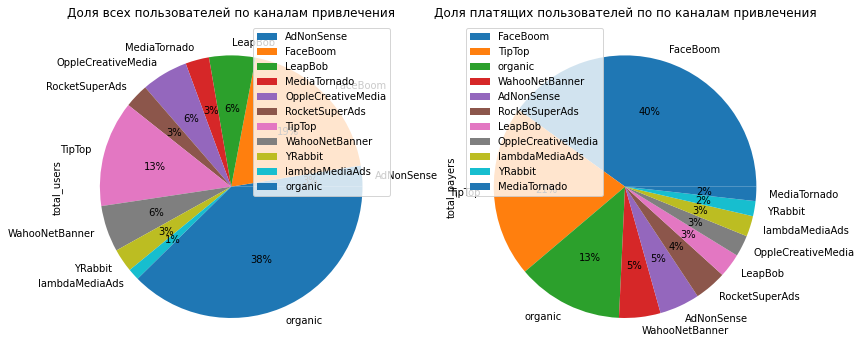

In [41]:
total_title = 'Доля всех пользователей по каналам привлечения'
payers_title = 'Доля платящих пользователей по по каналам привлечения'

plot_grouped(channel_grouped, channel_grouped_payers, total_title, payers_title)

**Вывод:** больше всего органических пользователей - 38%, далее идет канал FaceBoom, TipTop, LeapBob, OppleCreativeMedia и WahooNetBanner. Что касается платящих пользователей, то здесь больше всего покупателей пришли из FaceBoom - 40% - достаточно весомый процент, далее идет TipTop - 21%, на третьем месте органические пользователи - 13%(хороший показатель относительно платных источников привлечения, стоит обратить внимание на это!). Доля платящих пользоваталей относительно общего кол-ва пользоваталей по каналам: в топ три входят каналы FaceBoom, AdNonSense, lambdaMediaAds - более 10%.

### Маркетинг

 - Посчитаем общую сумму расходов на маркетинг.
 - Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
 - Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
 - Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

**Общая сумма расходов на маркетинг**

In [43]:
total_cost = profiles['costs'].sum()
print(f'Общая сумма расходов на маркетинг: {int(total_cost)}')

Общая сумма расходов на маркетинг: 13018376


**Рассмотрим распределение общих затрат на рекламу по каналам.**

In [43]:
(profiles.pivot_table(index='channel', values='costs', aggfunc='sum')
                   .sort_values(by='costs', ascending=False))

costs
channel                       
TipTop              6634745.90
FaceBoom            5670124.90
WahooNetBanner       274956.60
OppleCreativeMedia   115732.75
AdNonSense           101199.00
LeapBob               96408.27
RocketSuperAds        50786.71
YRabbit               26367.72
MediaTornado          25749.84
lambdaMediaAds        22304.80
organic                   0.00

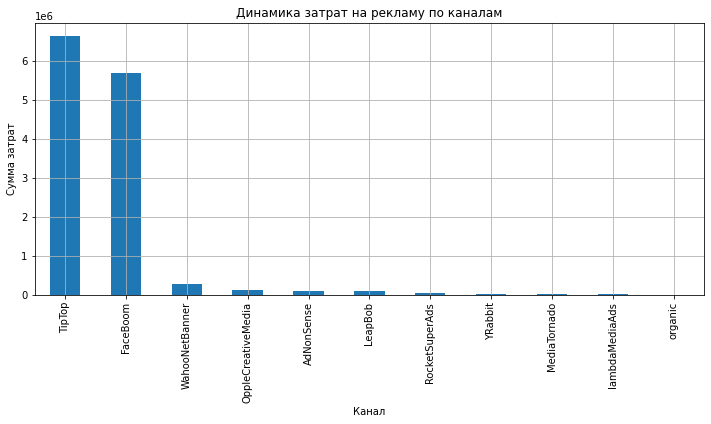

In [44]:
(profiles.pivot_table(index='channel', values='costs', aggfunc='sum')
                   .sort_values(by='costs', ascending=False)).plot(kind='bar', grid=True, legend=False, figsize=(12,5))

plt.title('Динамика затрат на рекламу по каналам')
plt.xlabel('Канал')
plt.ylabel('Сумма затрат')
plt.show()

**Вывод:** Лидерами по общим затратам на рекламу с огромным отрывом являются каналы TipTop и FaceBoom более 6 млн.дол. и 5.7млн.дол. соответственно, на их фоне остальные каналы еле заметны.

**Визуализация динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику**

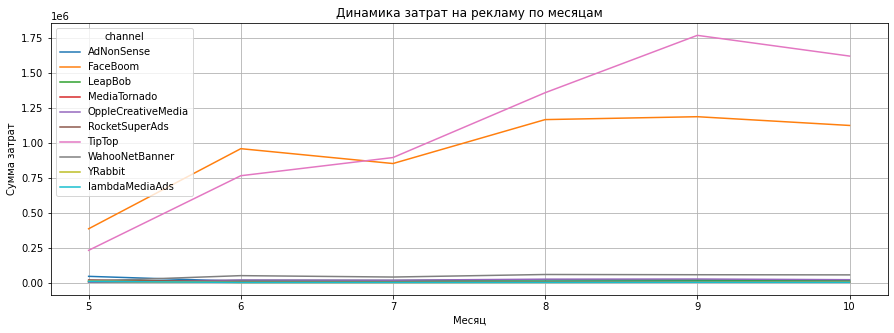

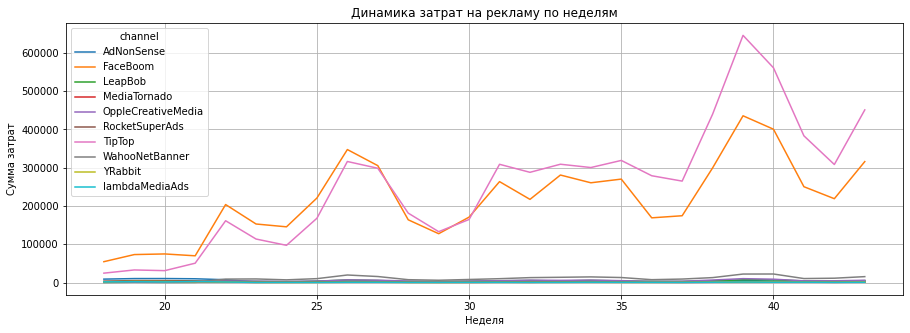

In [102]:
cost_grouped = profiles.copy()
cost_grouped['month'] = pd.to_datetime(cost_grouped['dt']).dt.month
cost_grouped['week'] = pd.to_datetime(cost_grouped['dt']).dt.isocalendar().week

result = cost_grouped.pivot_table(
            index='month', columns='channel', values='costs', aggfunc='sum')
result.plot(figsize=(15,5), grid=True)
plt.title('Динамика затрат на рекламу по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма затрат')

result = cost_grouped.pivot_table(
            index='week', columns='channel', values='costs', aggfunc='sum')
result.plot(figsize=(15,5), grid=True)

plt.title('Динамика затрат на рекламу по неделям')
plt.xlabel('Неделя')
plt.ylabel('Сумма затрат')
plt.show()

 **Вывод:**

 Исходя из построенных графиков видно:
 - стабильно активный рост вложений в каналы **TipTop** и **FaceBoom** - в сентрябре вложения в канал TipTop достигли 1.75 млн, а это очень много, вложения в остальные каналы стабильные на протяжении всех месяцев
 - похожие результаты мы видим на графике с разбивкой по неделям: динамика наблюдается у самых "затратных" каналов **TipTop** и **FaceBoom**, вложения в остальные каналы стабильные на протяжении всех недель.

Далее в анализе окупаемости рекламы стоит уделить больше внимания именно каналам **TipTop** и **FaceBoom**, можно предположить, что вложения именно в эти каналы не окупаются, судя по количеству затрат.


**Сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.**

In [104]:
(profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
                   .sort_values(by='acquisition_cost', ascending=False))

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172

In [108]:
(profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
                   .sort_values(by='acquisition_cost', ascending=False))

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172

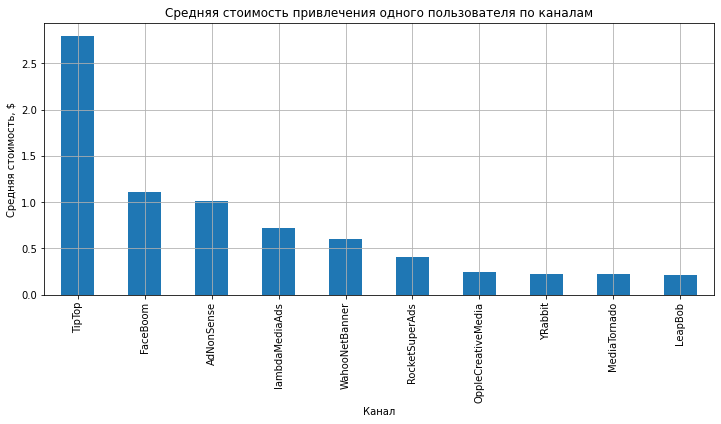

In [112]:
(profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
                   .sort_values(by='acquisition_cost', ascending=False)
                   .plot(kind='bar', figsize=(12,5), grid=True, legend=False))

plt.title('Средняя стоимость привлечения одного пользователя по каналам')
plt.xlabel('Канал')
plt.ylabel('Средняя стоимость, $')
plt.show()

**Вывод:** наглядно видно, что самым дорогим каналом с преимуществом в полтора раза является **TipTop** - почти 2.8 дол. за одного клиента, далее идут каналы **FaceBoom** и **AdNoneSense** - у них чуть больше 1 дол. за каждого клиента, самым "дешевым" каналом является LeapBob - 0.2 дол. за клиента.

### Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [46]:
observation_date = datetime(2019,11,1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

**Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.**

In [47]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

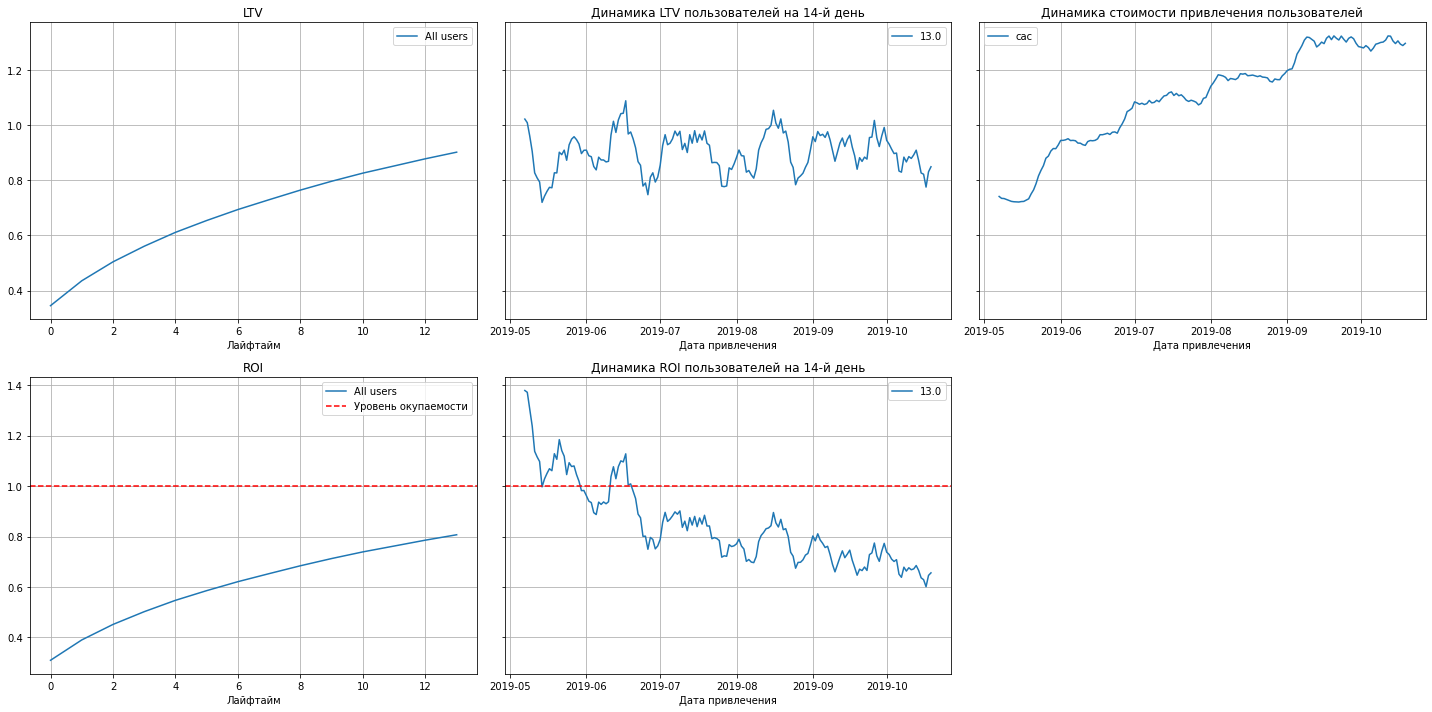

In [48]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:
 - стоимость привлечения пользоваталей растет, т.е. с каждым новом месяцем увеличивается бюджет на рекламу;
 - реклама не окупается, ROI в конце второй недели чуть выше 80%;
 - динамика ROI показывает, что в первые два месяца 14 дней хватало для окупаемость клиентов, однако с ростом бюджета на рекламу окупаемость снимажалась.
 - согласно графику LTV, общая сумма денег, которую клиент в среднем приносит компании стабильно возрастает к 14-ому лайфтайму 

**Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.**

In [49]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

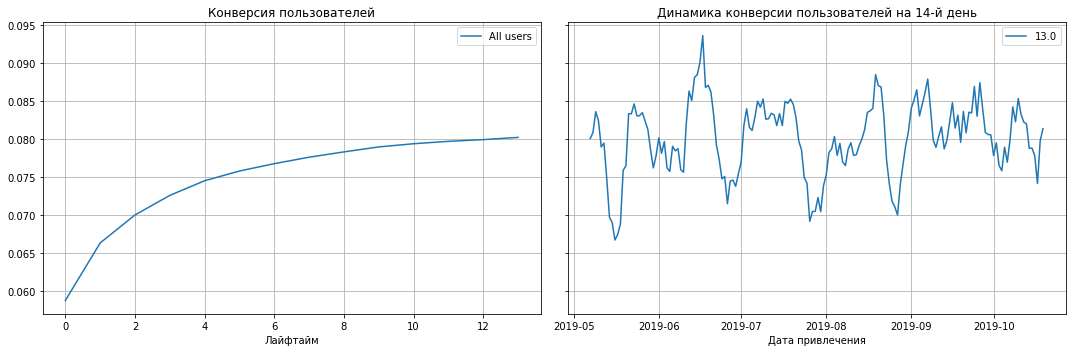

In [50]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

В целом можно сказать, что с лайфтаймом конверсия растет, к 14 дню она составляет около 8%.
Глядя на график динамики конверсии можно сказать, что процесс сам по себе не стабильный, например, в мае был провал в середине месяца - пользователи хуже конвертеровались, чем в начале и конце месяца. А вот в июне наоборот, больше всего "сконвертировавшихся" пользователей пришлось на середину месяца.

In [51]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

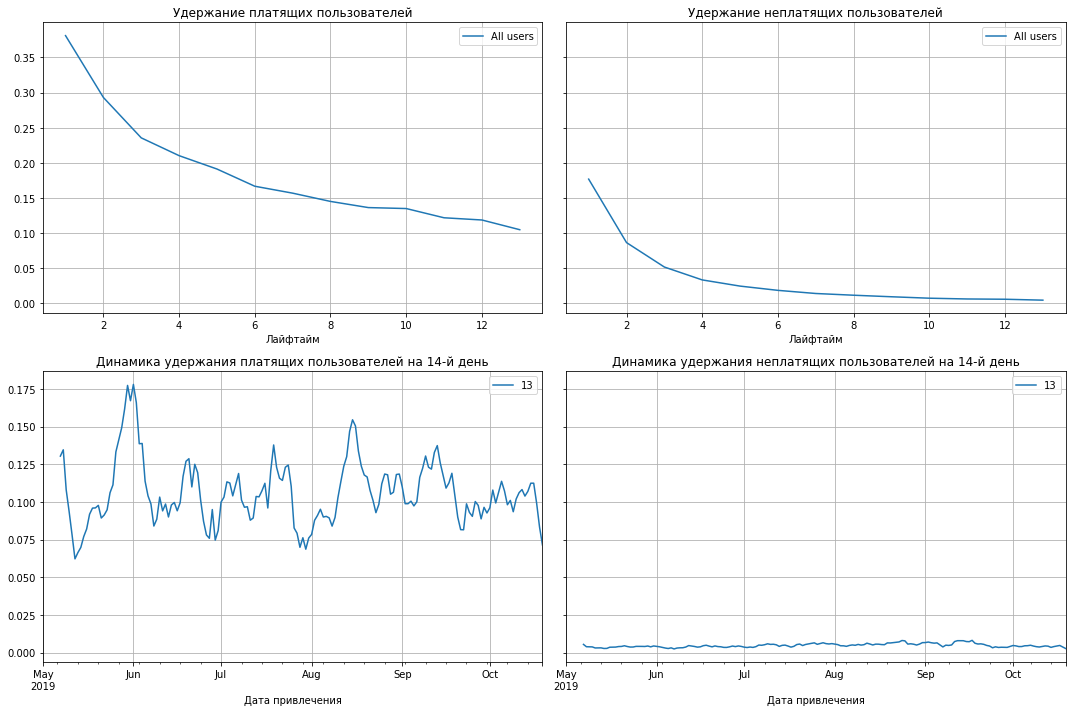

In [52]:
plot_retention(retention_grouped, retention_history, horizon_days) 

По общим графикам удеражния можно сказать, что пользователи плохо удерживаются, максимальное значение чуть больше 35%, динамика удержания неплатящих пользователей и вовсе приближается к нулю.

**Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

In [53]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

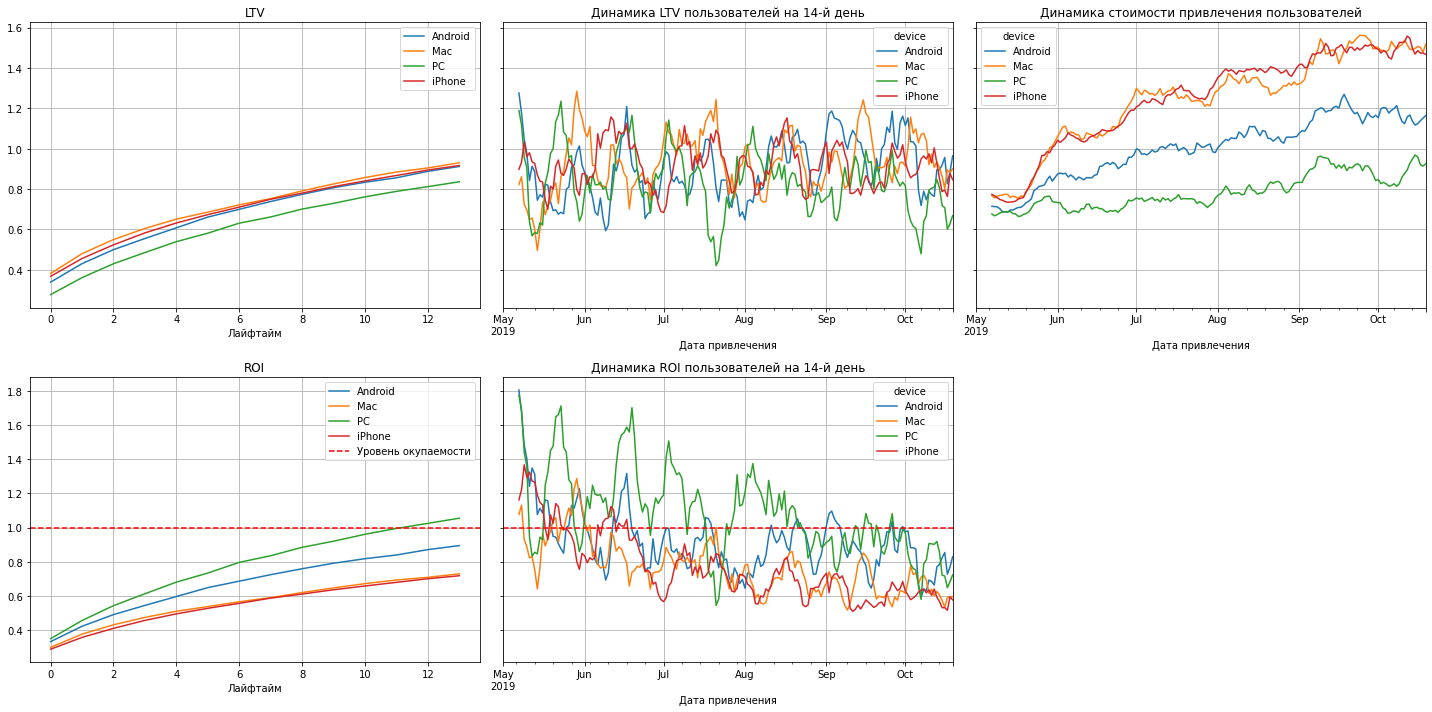

In [54]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать следующие выводы:
 - к концу лайфтайма реклама окупается только у пользователей PC
 - самые высокие затраты на рекламу для пользователей Mac и IPhone, однако с каждым новым месяцем окупаемость все ниже
 - LTV стабильно возрастает по всем устройствам

Посмотрим на **конверсию** и **удержание** с разбивкой по устройствам.

In [55]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

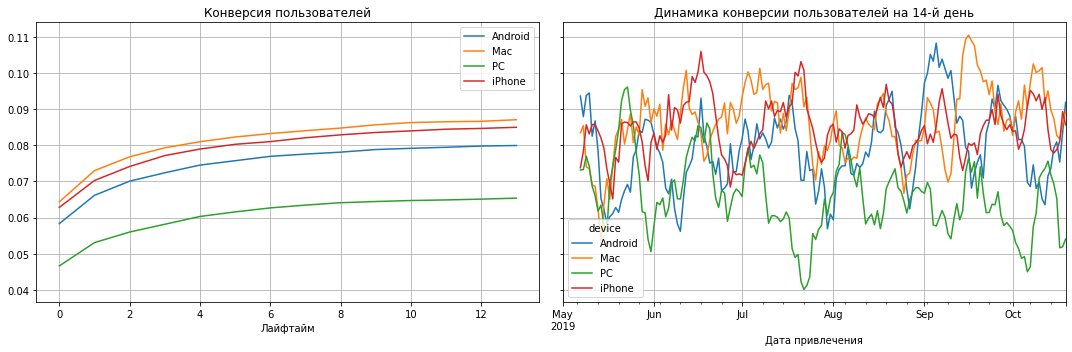

In [56]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Лучше всего конвертируются пользователи Mac, хуже всего - PC. Однако процент конвертации низкий, менее 10%.

In [57]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])

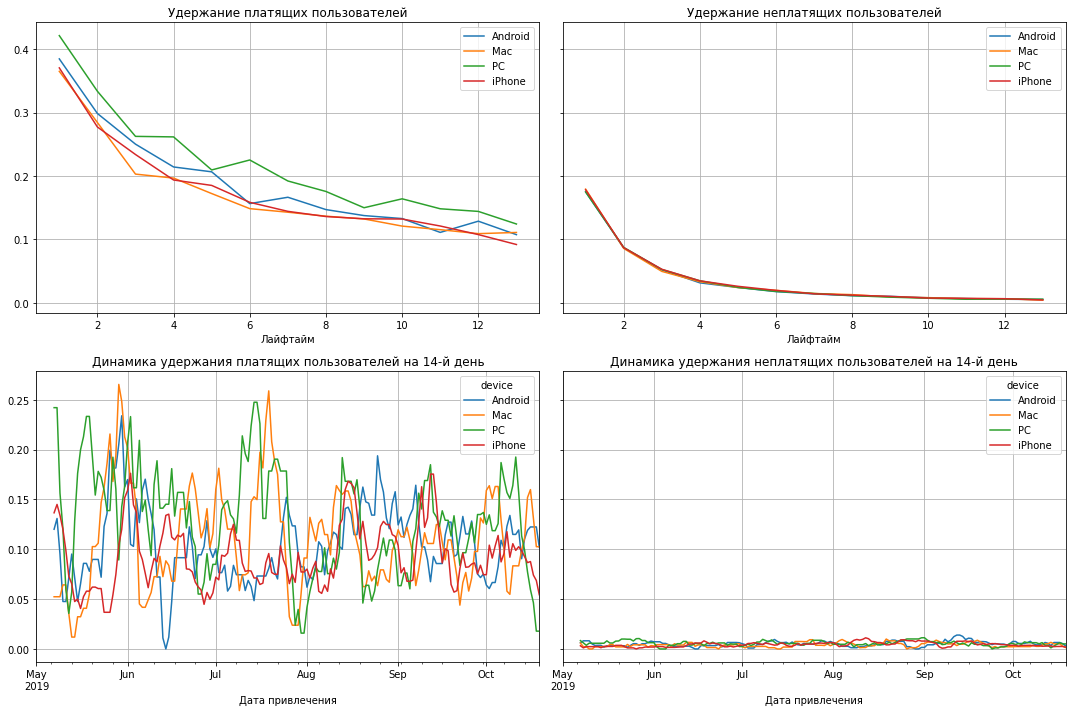

In [58]:
plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользоваталей по устройствам почти одинаковое, лучше всего удерживаются платящие пользователи PC, хуже всего - Mac. Неплатящие пользователи удерживаются стабильно плохо среди всех устройств.

**Общий вывод по показателям анализа окупаемости рекламы с разбивкой по устройствам.**

Реклама окупается только среди пользователей PC, это очевидно, т.к. в нее вкладывается меньше всего средств, а процент удержания этих пользователей выше, чем у остальных устройств. Необходимо пересмотреть рекламный бюджет, который вкладывается в первую очередь в Mac и Iphone, потому что у них он больше, чем у Android и PC. Далее вывести вложения в рекламу в стабильное состояние, не увеличивать бюджет ежемесячно, а поработать над удержанием клиентов, возможно пересмотреть пользовательский интерфейс. Судя по показателям удержания на Iphone и Mac программа работает менее качественно. С учетом того, что пользователей с этих каналов больше и конвертируются они лучше, относительно Android и PC.

**Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

In [59]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

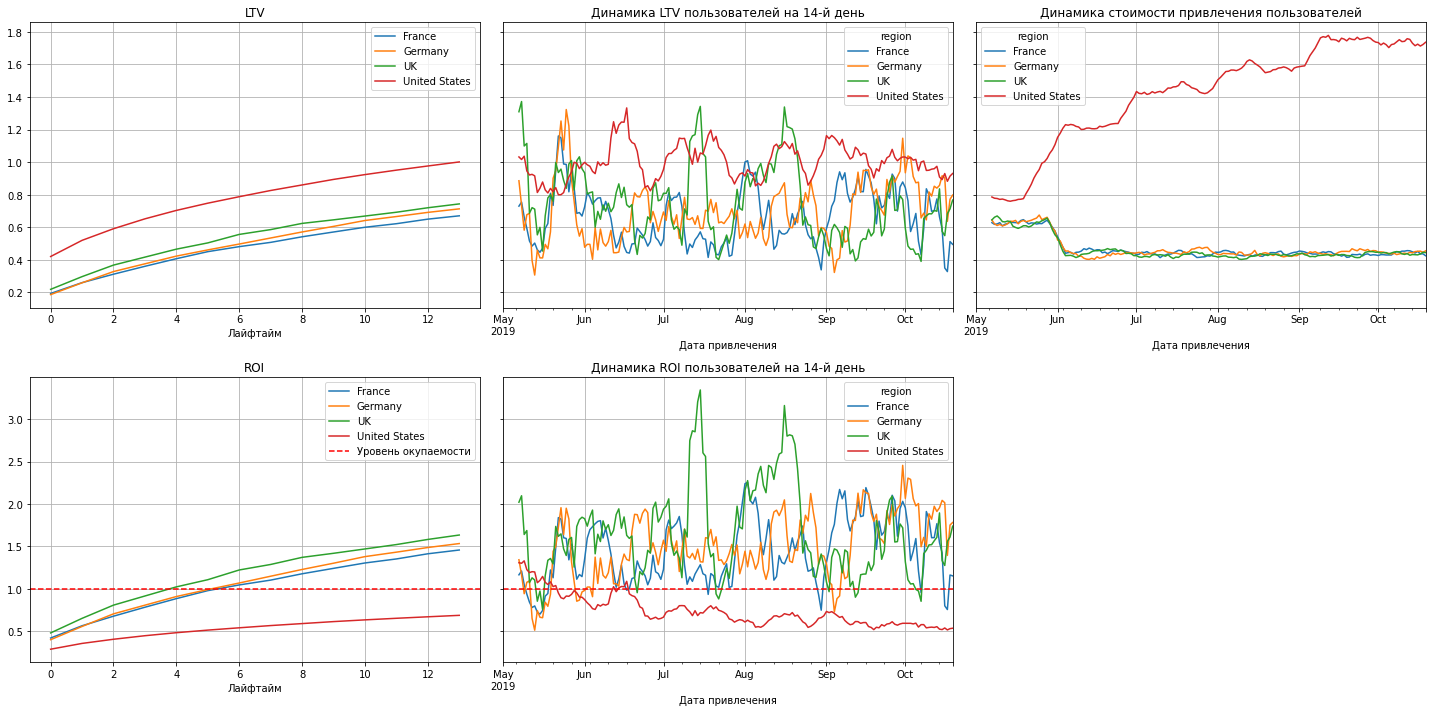

In [60]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать следующие выводы:
 - реклама не окупается только в США
 - динамика стоимости привлечения пользователей растет только в США, у остальных стран начиная с июня САС стабилен.
 - LTV США выше относительно других стран

Посмотрим на **конверсию** и **удержание** с разбивкой по странам.

In [61]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

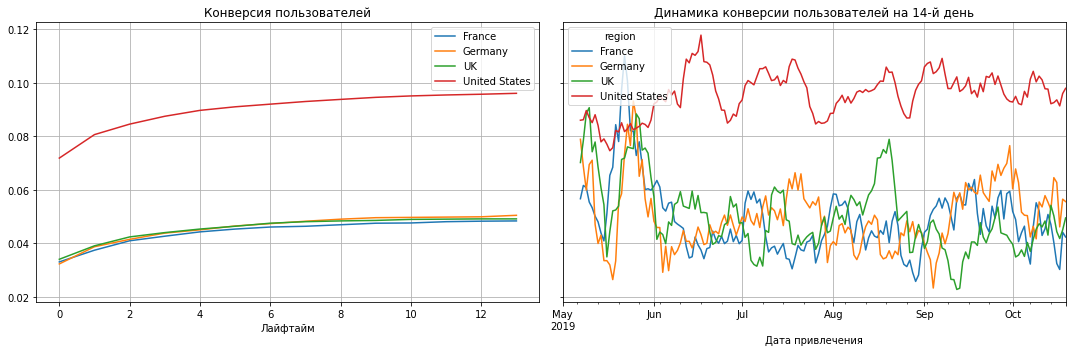

In [62]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Лучше всего конвертируются пользователи США, процент конверсии пользователей из Германии, Франции и Англии почти одинаковый.

In [63]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])

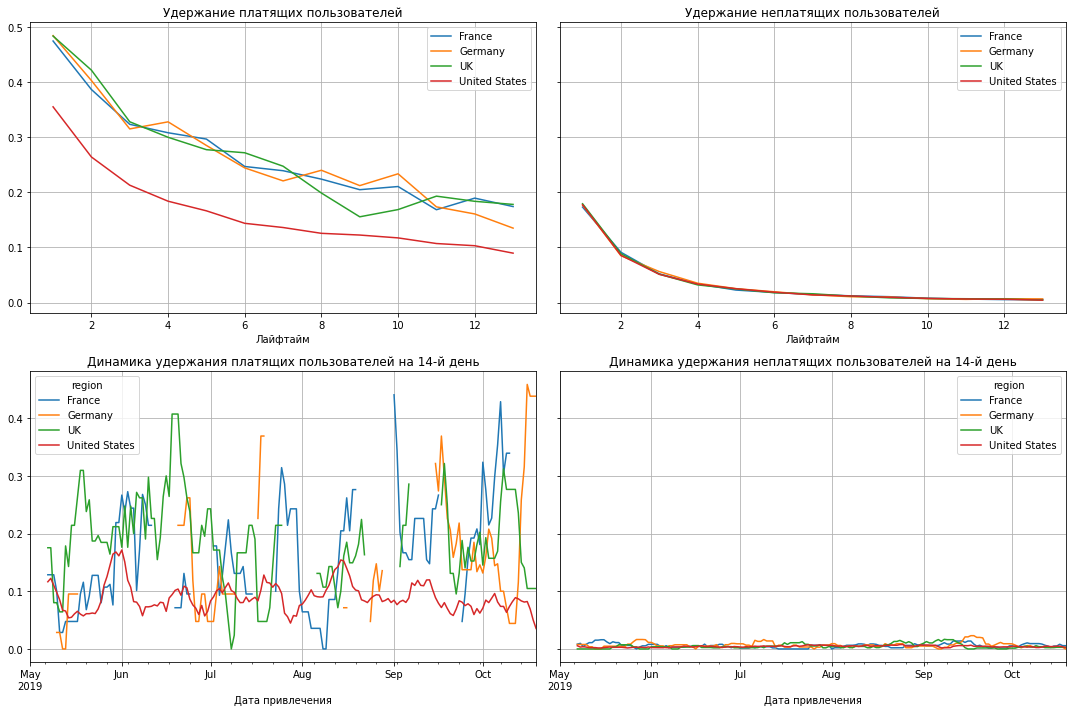

In [64]:
plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей из США хуже, чем у остальных стран - у них удержание почти одинаковое. Неплатящие пользователи не удерживаются вовсе.

**Общий вывод по показателям анализа окупаемости рекламы с разбивкой по странам**

Больше всего пользователей из США, у них же самая высокая конверсия, однако процент удеражния хуже всего, также это единственные пользователи, у которых не окупается реклама. Все потому, что ежемесячно динамика вложения средств в рекламу для пользователей США растет. Необходимо пересмотреть бюджет и стабилизировать затраты на рекламу, при этом поработов над удержанием клиентов из США. Чем выше будет процент удержания, тем лучше будет окупаться реклама.

**Рассмотрим графики LTV и ROI, а также графики динамики LTV, CAC и ROI разрезе страна-устройство в Европе (Англия, Франция, Германия)** 

In [65]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['europe','device'])
ltv_grouped = ltv_grouped.query('europe == True')
ltv_history = ltv_history.query('europe == True')
roi_grouped = roi_grouped.query('europe == True')
roi_history = roi_history.query('europe == True')

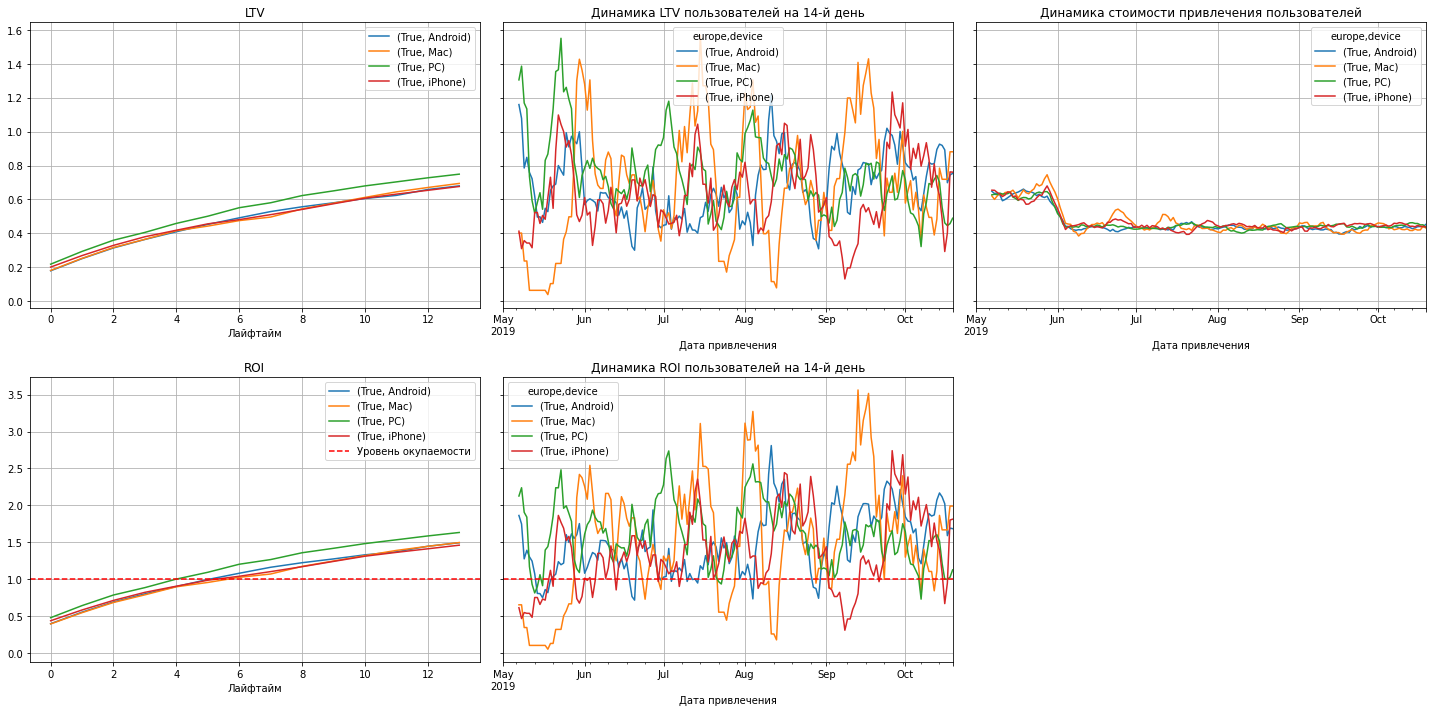

In [66]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод:** здесь у нас отличные показатели. LTV стабильно растет, лучший показатель у PC (самое большое кол-во пользователей в Европе именно с PC), реклама стабильно хорошо окупается по всем устройствам во всей Европе и затраты на рекламу стабильные, без выбросов.

**Рассмотрим конверсию и удержание в разрезе страна-устройство в Европе (Англия, Франция, Германия)**

In [67]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['europe', 'device'])
conversion_grouped = conversion_grouped.query('europe == True')
conversion_history = conversion_history.query('europe == True')

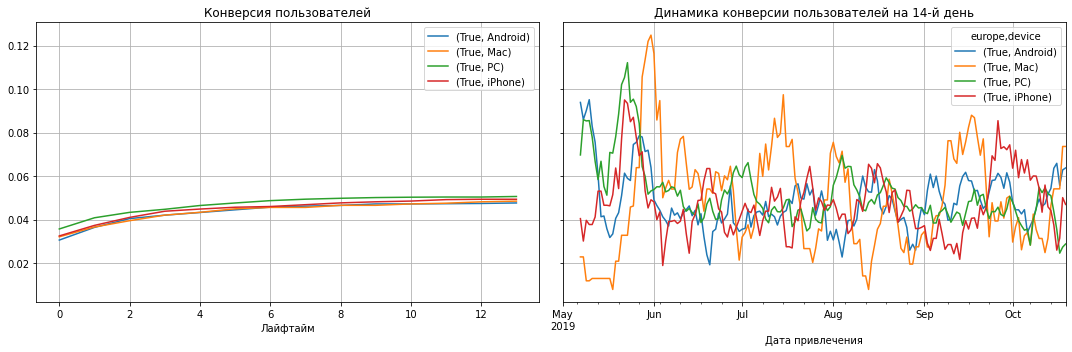

In [68]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

In [69]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['europe','device'])
retention_grouped = retention_grouped.query('europe == True')
retention_history = retention_history.query('europe == True')

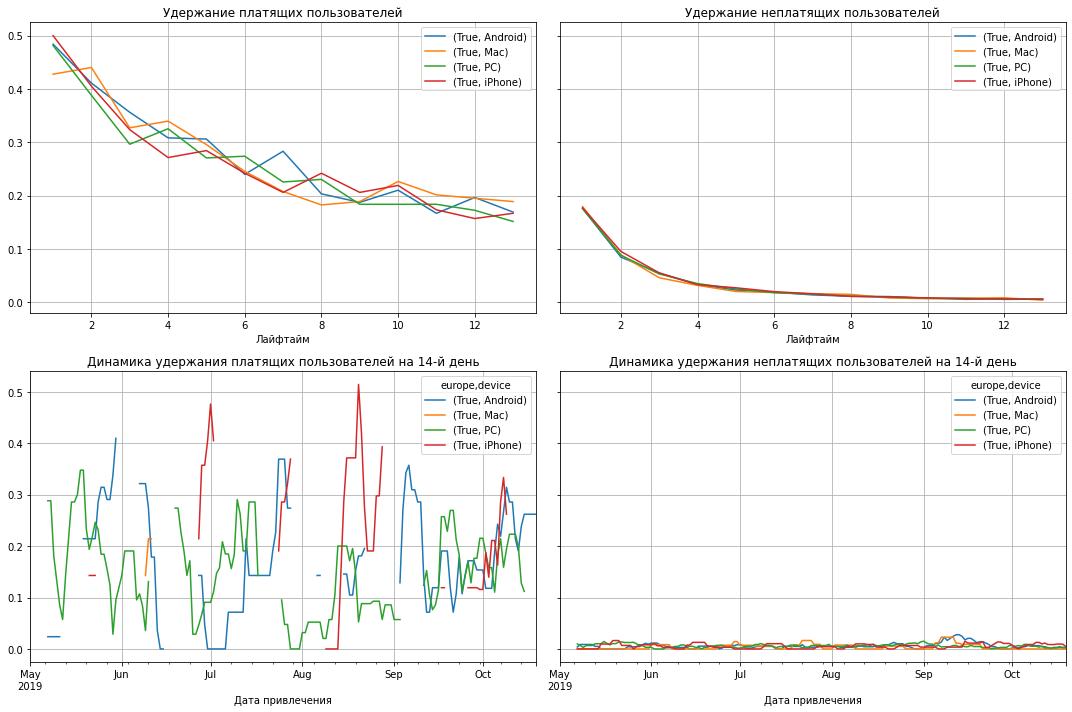

In [70]:
plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:** явных аутсайдеров нет, конверсия одинаковая среди всех устройств, PC слегка лидирует. Удержание по устройствам тоже +- одинаковое, немного проседает iPhone, но это и очевидно, т.к. из исследовательского анализа мы знаем, что в Европе самыми активными пользователями являются пользователи PC. 

**Рассмотрим графики LTV и ROI, а также графики динамики LTV, CAC и ROI в разрезе страна-устройство в США**

In [71]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['us','device'])
ltv_grouped = ltv_grouped.query('us == True')
ltv_history = ltv_history.query('us == True')
roi_grouped = roi_grouped.query('us == True')
roi_history = roi_history.query('us == True')

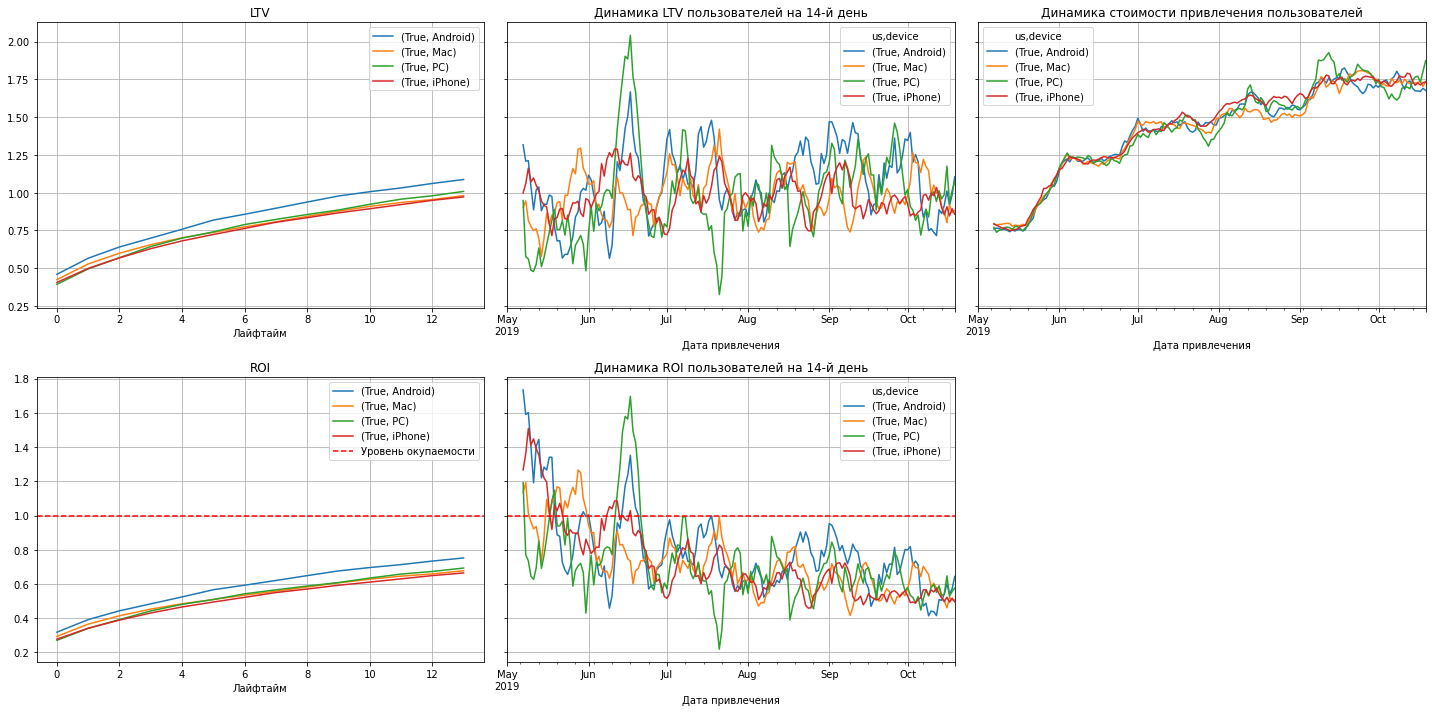

In [72]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод:** а вот здесь, в отличии от показателей в Европе, все куда хуже: реклама не окупается ни по одному из устройств при постоянном росте затрат на привлечение пользоваталей, LTV самый высокий у Android, хотя мы знаем, что самое большое кол-во пользователей iPhone.

**Рассмотрим конверсию и удержание в разрезе страна-устройство в США**

In [73]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['us', 'device'])
conversion_grouped = conversion_grouped.query('us == True')
conversion_history = conversion_history.query('us == True')

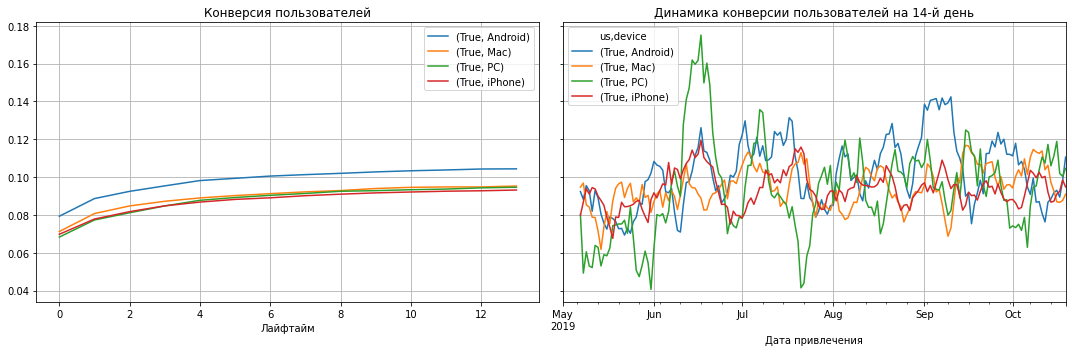

In [74]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

In [75]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['us','device'])
retention_grouped = retention_grouped.query('us == True')
retention_history = retention_history.query('us == True')

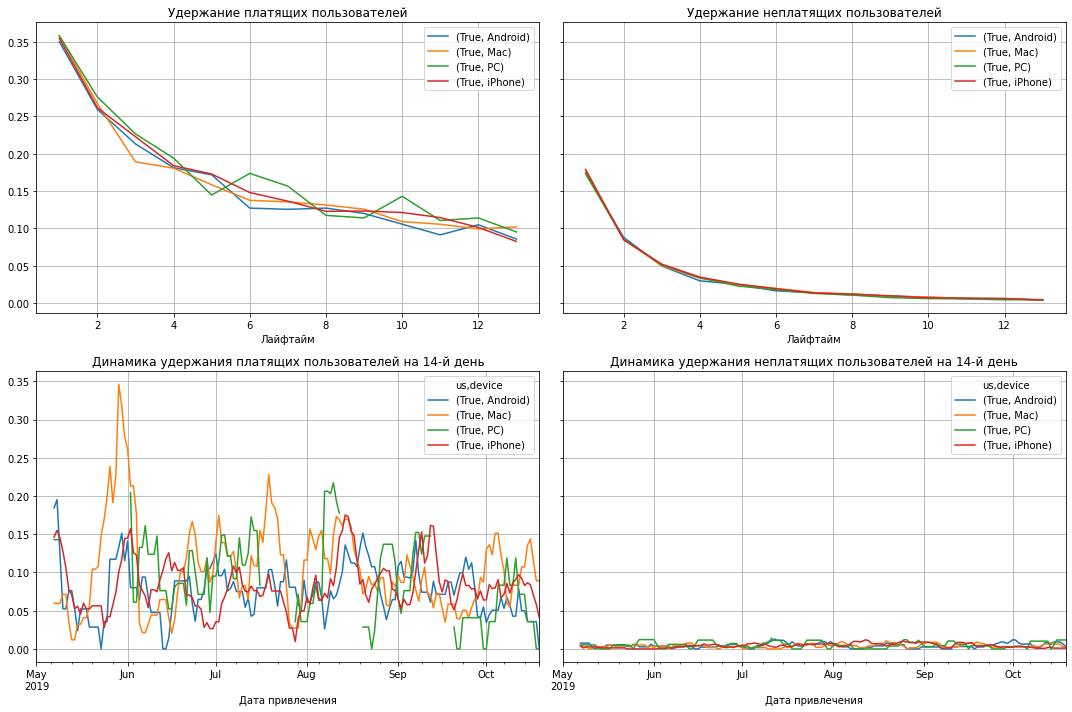

In [76]:
plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:** самая высокая конверсия у пользователей Android, если сравнить графики удержания по устройствам в Европе и США, то в США этот показатель примерно на 10% ниже.

**Общий вывод по показателям анализа окупаемости рекламы в разрезе страна-устройство**

Исходя из проведенного анализа можно сделать вывод, что в первую очередь необходимо пересмотреть работу отдела маркетинга направленного на пользоваталей США. Согласно разрезу страна-устройство, США значительно уступает Европе, вложения в привлечение пользователей ежемесячно растет, однако это не окупается ни по одному из устройств, наряду с низким процентом удержания. Что касается пользоваталей из Европы и результатов среза страна-устройство, то они очень хорошие, затраты на рекламу стабильные и при этом хорошо окупаются. В целом можно поработать над повышением процента удержания пользователей.

Таким образом получилось выяснить, что основной причиной отсутствия окупаемости рекламы являются пользователи из США, т.к. мы знаем, что их самое большое кол-во, из которых 45% пользователей пользуются iPhone и 25% - Mac.
    
Рекомендация: необходимо провести дополнительный анализ качества приложения в разрезе пользователей США с разбивкой по устройствам, возможно собрать отзывы и тд.

**Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

In [77]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

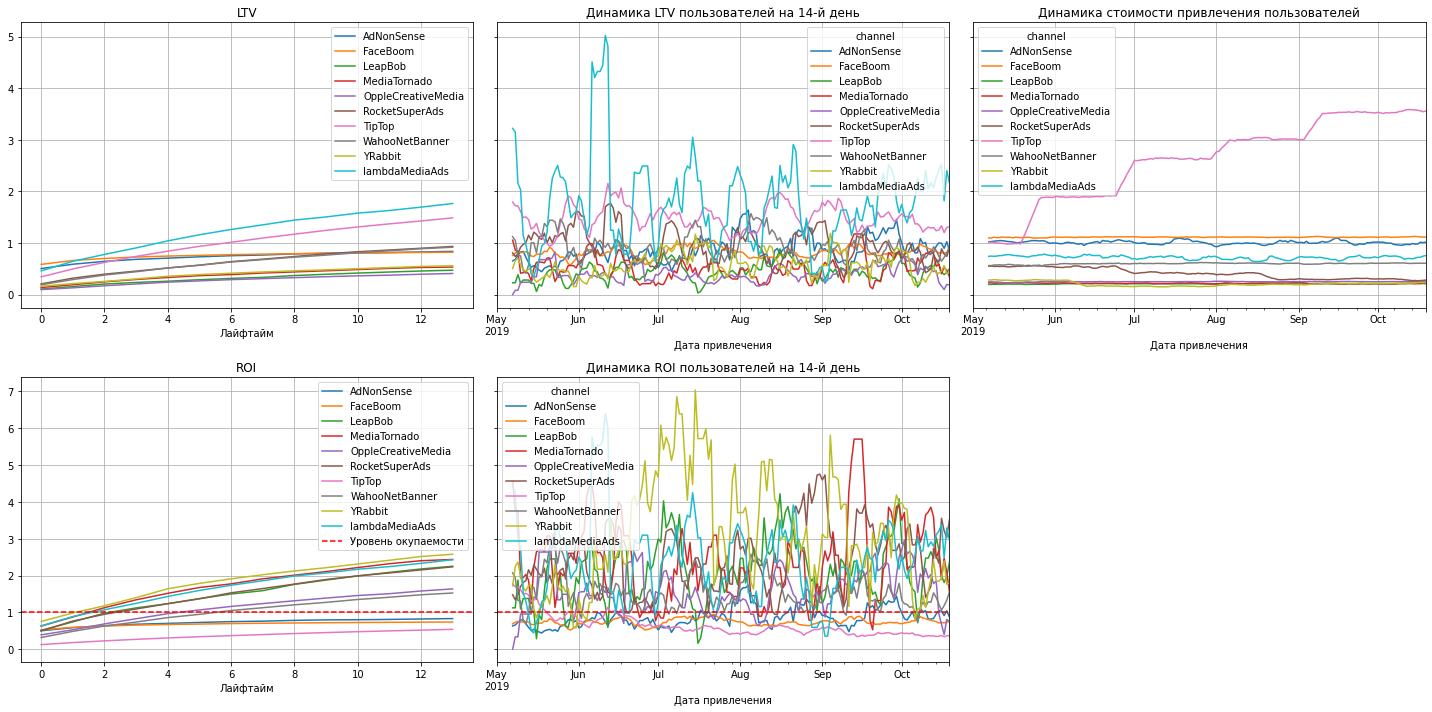

In [78]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать следующие выводы:
 - не окупаемыми каналами являются AdNonSense, FaceBoom, TipTop
 - стоимость привлечения пользователей через канал TipTop нестабильна
 - LTV стабильно возрастает
 - лучше всего окупаются каналы YRabbit, MediaTornado, lambdaMediaAds

Посмотрим на **конверсию** и **удержание** с разбивкой по каналам привлечения.

In [79]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

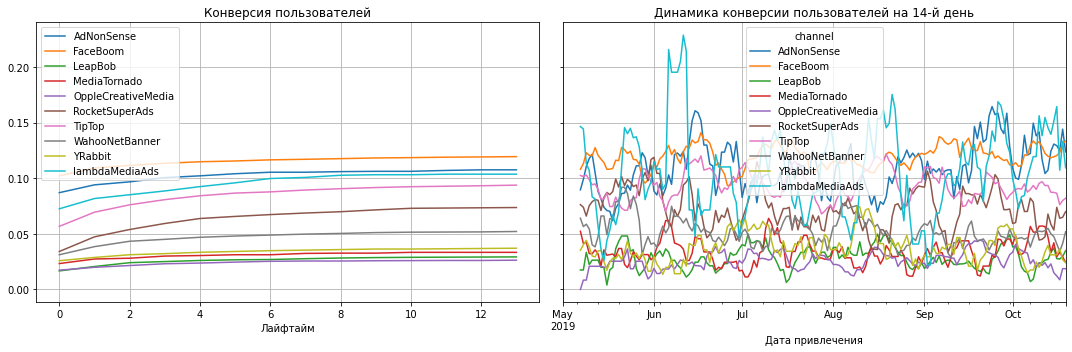

In [80]:
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируются пользователи из канала FaceBob, в июне у канала lambdaMediaAds был аномальный скачок конверсии, более 20%.

In [81]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])

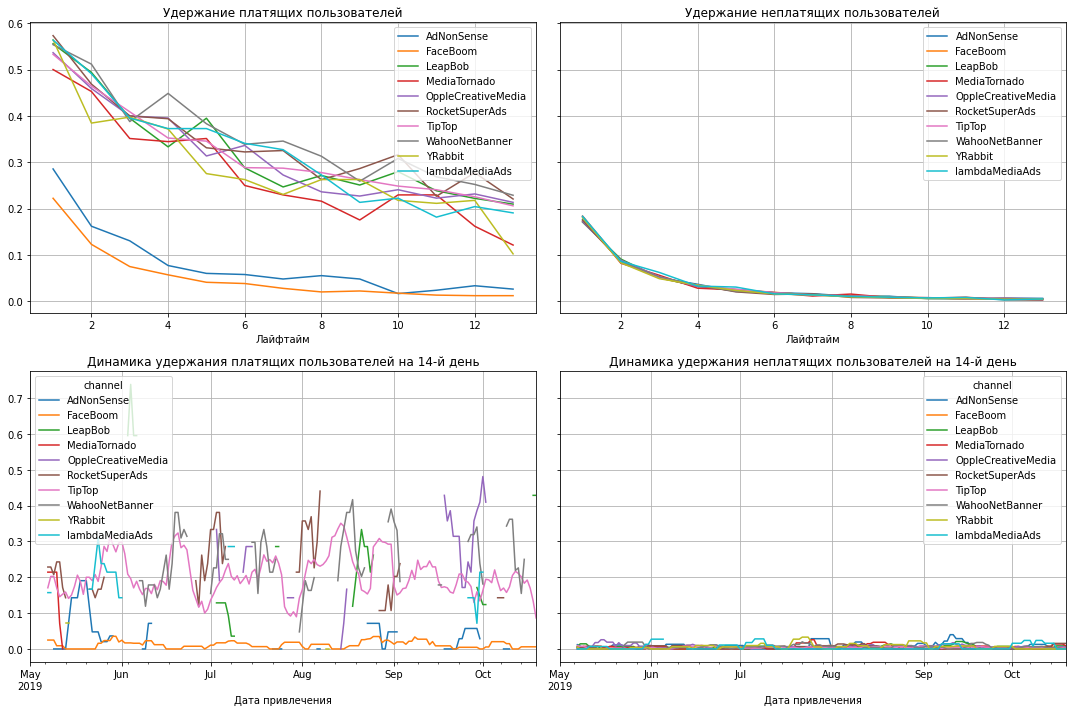

In [82]:
plot_retention(retention_grouped, retention_history, horizon_days)

Самое низкое удержание платящих пользователей по каналам FaceBoom и AdNonesense, неплатящие пользователи не удерживаются совсем.

**Общий вывод по показателям анализа окупаемости рекламы с разбивкой по каналам**

Самое большое количество платящих пользователей пришли из канала FaceBoom, у пользователей из этого канала также самая высокая конверсия, однако удержание низкое. Стоит обратить внимание на канал TipTop - это единственный канал, динамика стоимости привлечения пользователей которого ежемесячно растет. Необходимо стабилизировать вложнение средств в этот канал, также пересмотреть бюджет вложения в каналы AdNonSense, FaceBoom, т.к. эти каналы не окупают вложенные в них средства.

**Рассмотрим графики LTV и ROI, а также графики динамики LTV, CAC и ROI в разрезе страна-канал в Европе**.

Отметим здесь каналы, затраты на которые согласно проведенному выше анализу не окупаются - AdNonSense, FaceBoom, TipTop

In [83]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['europe','channel'])
ltv_grouped = ltv_grouped.query('europe == True')
ltv_history = ltv_history.query('europe == True')
roi_grouped = roi_grouped.query('europe == True')
roi_history = roi_history.query('europe == True')

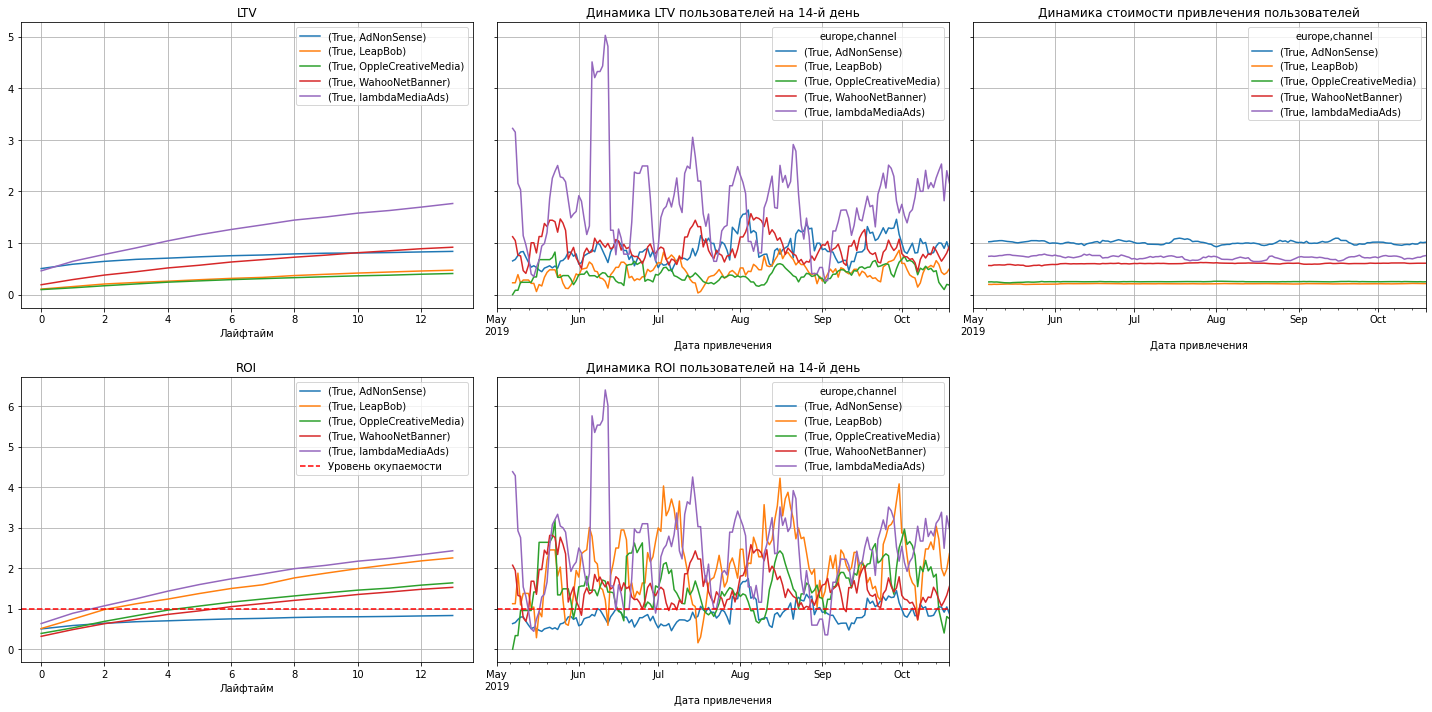

In [84]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод:** самым дорогим каналом привлечения можно считать AdNonSense, несмотря на стабильную динамику, это единственный канал, вложения в который в Европе не окупаются. Лидерами по окупаемости являются lamdaMediaAds и LeapBob, больше всего пользователей приходит из канала lamdaMediaAds.

**Рассмотрим конверсию и удержание в разрезе страна-канал в Европе**

In [85]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['europe', 'channel'])
conversion_grouped = conversion_grouped.query('europe == True')
conversion_history = conversion_history.query('europe == True')

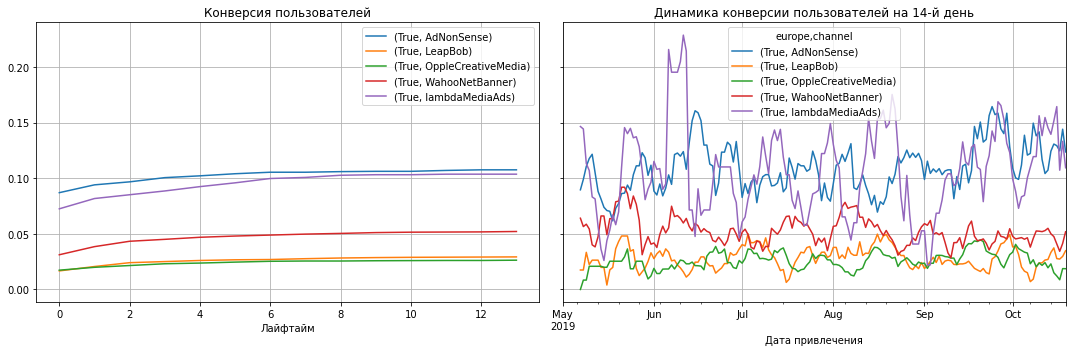

In [86]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:** Самая низкая конверсия в Европе наблюдается по каналам OppleCreativeMedia, LeapBob, самая высокая - AdNoneSense и lambdaMediaAds.

In [87]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['europe', 'channel'])
retention_grouped = retention_grouped.query('europe == True')
retention_history = retention_history.query('europe == True')

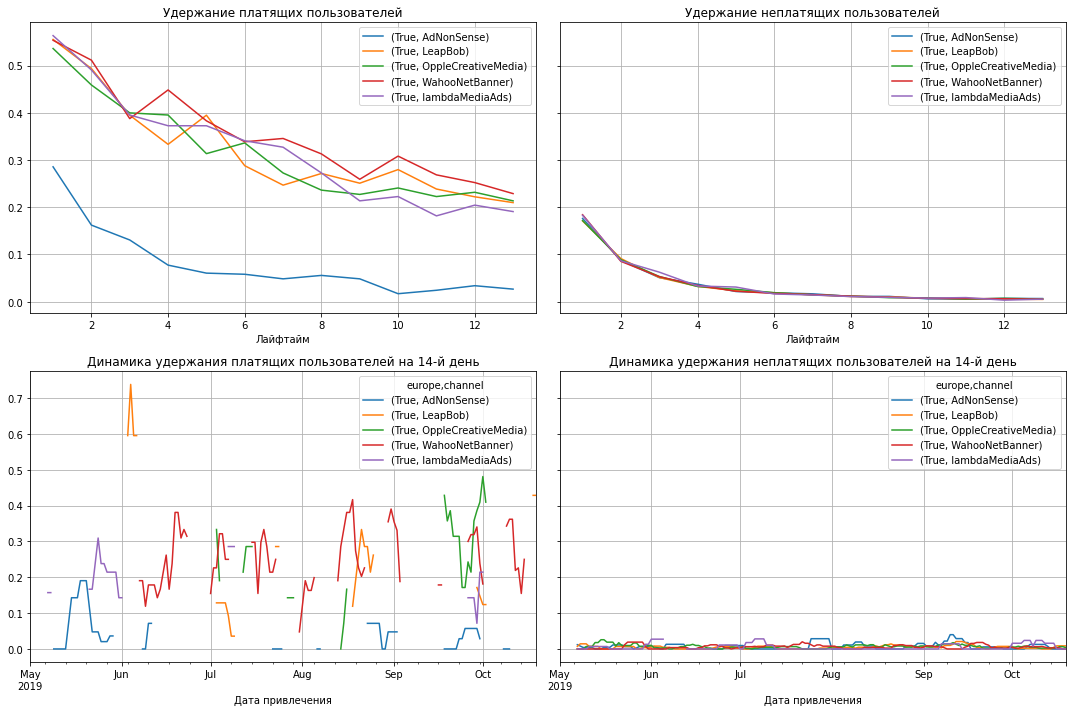

In [88]:
plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:** Несмотря на самую высокую конверсию, удержание по каналу AdNoneSense самое низкое, самое высокое удержание наблюдается по каналам WahooNetBanner и lambdaMediaAds.

**Рассмотрим графики LTV и ROI, а также графики динамики LTV, CAC и ROI в разрезе страна-канал в США**.

In [89]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['us','channel'])
ltv_grouped = ltv_grouped.query('us == True')
ltv_history = ltv_history.query('us == True')
roi_grouped = roi_grouped.query('us == True')
roi_history = roi_history.query('us == True')

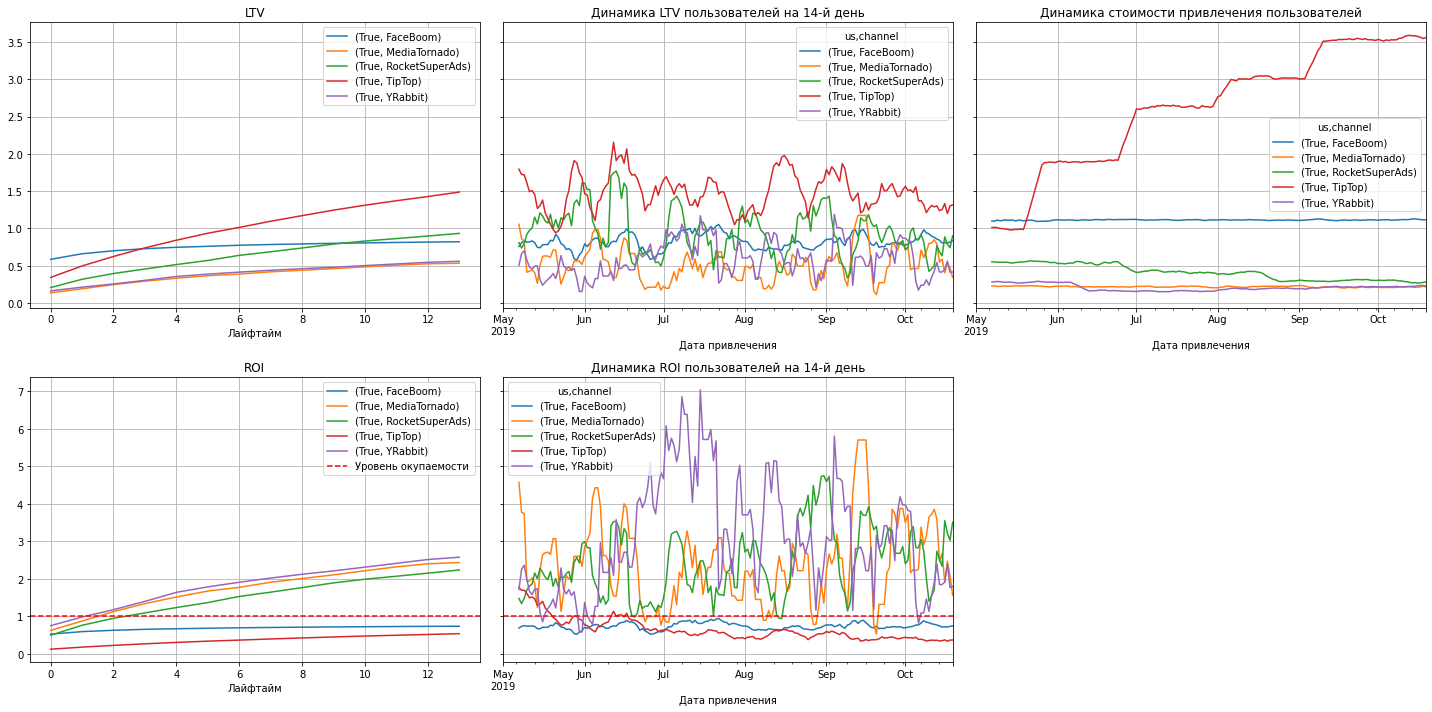

In [90]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод:** Больше всего пользователей приходит из канала TipTop, также это единственный канал, стоимость привлечения пользователей которого ежемесячно растет. Не окупаются два канала - TipTop и FaceBoom, лучше всего окупаются YRabbit и MediaTornado, однако по этим каналам самый низкий LTV и соответственно стоимость привлечения.

**Рассмотрим конверсию и удержание в разрезе страна-канал в США**

In [91]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['us', 'channel'])
conversion_grouped = conversion_grouped.query('us == True')
conversion_history = conversion_history.query('us == True')

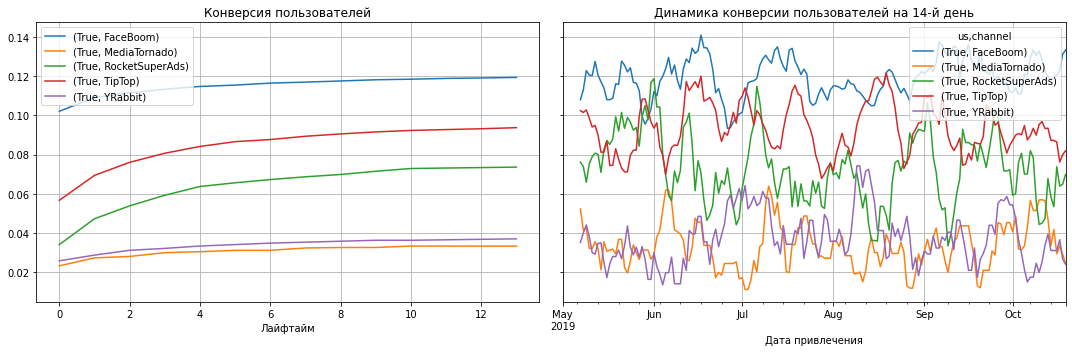

In [92]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Самая высокая конверсия у каналов FaceBoom и TipTop, самая низкая у YRabbit и MediaTornado.

In [93]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['us', 'channel'])
retention_grouped = retention_grouped.query('us == True')
retention_history = retention_history.query('us == True')

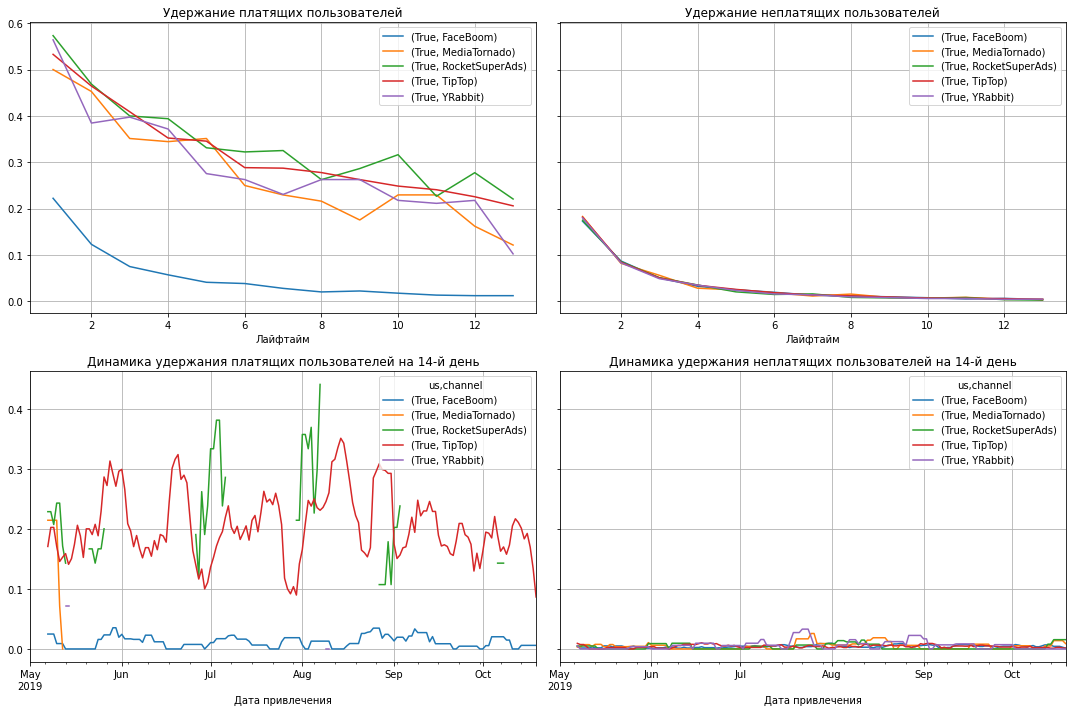

In [94]:
plot_retention(retention_grouped, retention_history, horizon_days)

Самое низкое удержание у канала FaceBoom, даже пользователи канала TipTop удерживаются неплохо.

**Общий вывод по показателям анализа окупаемости рекламы в разрезе страна-канал**

Опираясь на выводы, сделанные при анализе LTV, CAC, ROI, конверсии и удержания данных по *каналам*, мы знаем, что: 
 - в топ-4 по стоимости привлечения пользоваталей входят - **TipTop, FaceBoom, AdNoneSense, lambdaMediaAds**
 - не окупаемыми каналами являются **AdNonSense, FaceBoom, TipTop**
 - лучше всего окупаются каналы **YRabbit, MediaTornado, lambdaMediaAds**   
 - стоимость привлечения пользователей через канал **TipTop** ежемесячно растет
 - самое низкое удержание платящих пользователей по каналам **FaceBoom и AdNonesense**

В результате анализа показателей LTV, CAC, ROI, конверсии и удержания в разрезе *страна-канал*, получились следующие выводы:

 - самый дорогой канал привлечения в **Европе** - **AdNonSense**, 
 - несмотря на стабильную динамику, **AdNonSense** - это единственный канал, вложения в который в Европе не окупаются
 - лучше всего в европейских показателях окупаются каналы **lamdaMediaAds** и **LeapBob** 
 - больше всего европейских пользователей приходит из канала **lamdaMediaAds**
    
    
 - в **США** больше всего пользователей приходит из канала **TipTop** 
 - **TipTop** - это единственный канал, стоимость привлечения пользователей которого ежемесячно растет
 - в **США** не окупаются два канала - **TipTop** и **FaceBoom**
 - лучше всего в **США** окупаются **YRabbit** и **MediaTornado**, однако по этим каналам самый низкий LTV и соответственно стоимость привлечения.   
</font>

## Общий вывод

Если подытожить, мы имеем три основных показателя, по которым были рассчитаны LTV, CAC и ROI - страна, устройство, канал привлечения.

Если посмотреть на каналы привлечения, то удержание пользователей достаточно высокое, кроме каналом FaceBoom и AdNone Sense, но это скорее связано с устройствами, которыми пользовались пользователи при переходе в приложение.
Можно предположить, что неэффективность привлечения пользователей связана с неграмотным подходом к использованию бюджета, выделяемого на рекламу. **В каждом из показателей динамика стоимости привлечения пользователей нестабильна**:
 - в разбивке по странам: больше всего средств вкладывается в пользователей из США, потому что их более 100 тыс., однако удержание этих пользователей самое низкое, поэтому нет результатов.
 - в разбивке по устройствам: больше всего средств вкладывается в пользователей iPhone и Mac, однако удержание этих пользоваталей также самое низкое.
 - в разбивке по каналам привлечения: здесь стоит учесть, что органических платящих пользоваталей целых 13%, однако стоит пересмотреть вложения в канал TipTop - это один из каналов, вложения в который ежемесячно растут, но не окупаются.

**Также дополнительно были проведены анализ показателей в разрезе страна-устройство и страна-канал**.  

Исходя из результатов анализа в разрезе **страна-устройство**, были сделаны следующие выводы:
 - в **США** вложения в привлечение пользователей ежемесячно растет, однако это не окупается ни по одному из устройств, наряду с низким процентом удержания. 
 -  показатели **европейских** метрик очень хорошие - затраты на рекламу стабильные и при этом хорошо окупаются

Таким образом получилось выяснить, что основной причиной отсутствия окупаемости рекламы являются пользователи из США, т.к. мы знаем, что их самое большое кол-во, из которых 45% пользователей пользуются iPhone и 25% - Mac.

Рекомендация: необходимо провести дополнительный анализ качества приложения в разрезе пользователей США с разбивкой по устройствам, возможно собрать отзывы 
    
В результате анализа в разрезе **страна-канал**, получились следующие выводы:

 - самый дорогой канал привлечения в **Европе** - **AdNonSense**, 
 - несмотря на стабильную динамику, **AdNonSense** - это единственный канал, вложения в который в Европе не окупаются
 - лучше всего в европейских показателях окупаются каналы **lamdaMediaAds** и **LeapBob** 
 - больше всего европейских пользователей приходит из канала **lamdaMediaAds**
    
    
 - в **США** больше всего пользователей приходит из канала **TipTop** 
 - **TipTop** - это единственный канал, стоимость привлечения пользователей которого ежемесячно растет
 - в **США** не окупаются два канала - **TipTop** и **FaceBoom**
 - лучше всего в **США** окупаются **YRabbit** и **MediaTornado**, однако по этим каналам самый низкий LTV и соответственно стоимость привлечения.   
    
**Рекомендации:** необходимо приостановить вложение в рекламу пользователей из США в канал TipTop и посмотреть в сторону каналов, которые окупаются - YRabbit и MediaTornado, сделать упор на работу над удержанием пользователей. Что касается каналов привлечения европейских пользоваталей, то здесь необходимо снизить траты на канал AdNonSense и вложиться в более эффективный - lambdaMediaAds - из этого канала приходит больше всего пользователей, он лучше всего окупается при достаточно высоких вложениях на привлечение пользователей.    
</font>    

Необходимо пересмотреть стратегию распределения бюджета в первую очередь по устройствам, стабилизировать его и, возможно, поработать над качеством продукта на IPhone и Mac, тщательно мониторить процент удержания пользователей, а не их общее количество. Вывести процент удержания на стабильно высокий уровень, а затем уже увеличивать бюджет на рекламу. Тоже самое касается и распределения рекламных средств по странам - приостановить вложение средств в рекламу и поработать над удержанием, в первую очередь клиентов из США. 